# Import libraries

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [59]:
#Encoders for categorial features
from sklearn.preprocessing import OneHotEncoder   
from sklearn.preprocessing import LabelEncoder
from category_encoders.count import CountEncoder

#Light Gradient Boosting Model
from lightgbm import LGBMClassifier

#Optuna for hyperparameters optimization
import optuna

#Other libraries
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.simplefilter("ignore")

# Load Data

In [60]:
Train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
X_val = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
print("Train shape: ", Train.shape)
print("Test shape: ", X_val.shape)
Train.head()

Train shape:  (750000, 18)
Test shape:  (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


# EDA (Exploratory Data Analysis)

In [61]:
# statistics of Train Dataframe's numerical features
Train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [62]:
# statistics of Test Dataframe's numerical features
X_val.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [63]:
#Frequency of each distinct categorial features in Train Dataframe
for column in Train.select_dtypes(include='object').columns:
    print("*"*25)
    print(Train[column].value_counts())

*************************
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64
*************************
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64
*************************
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64
*************************
default
no     737151
yes     12849
Name: count, dtype: int64
*************************
housing
yes    411288
no     338712
Name: count, dtype: int64
*************************
loan
no     645023
yes    104977
Name: count, dtype: int64
*************************
contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64
****************

<Axes: >

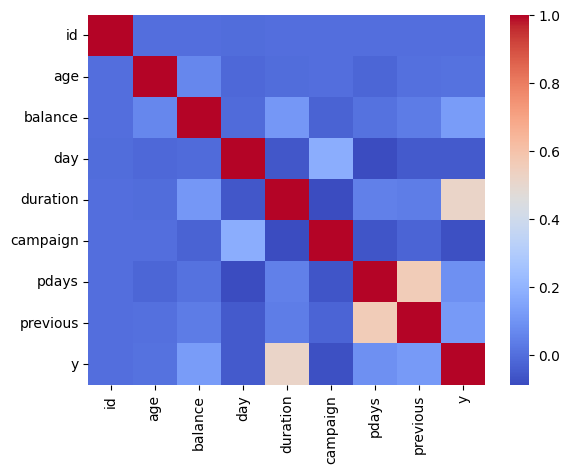

In [64]:
#Heat map  correlation of numerical features and target in Train Dataframe
sns.heatmap(Train.select_dtypes(include= np.number ).corr(), cmap= 'coolwarm')
#We can see higher correlation between duration - target and previous - target then between other features

We can see a high correlation between the "duration" and the target variable. Also we can see a high correlation between "pdays" and "previous".

<BarContainer object of 31 artists>

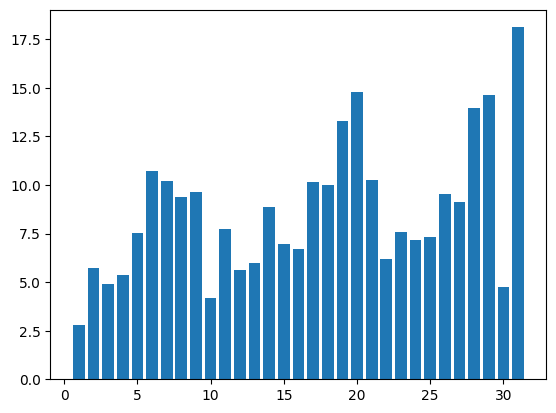

In [65]:
#Let's analyze the distribution of successful calls by days of the month.

Df_group = Train.groupby("day")['y'].agg(['count', 'sum'])
Df_group["success"] = Df_group["count"]/Df_group["sum"]
plt.bar( Df_group.index, Df_group.success)

# We can see that:

#1. the share of successful calls differs significantly on different days
#2. On last day of month  share of successful calls is increasing, but model don't know which day is last in different months

#So, I am going to do:

#1. add feature "last_day" : "yes" or "no" : is "day" last day in "month"?
#2. feature "day" code whith OneHotEncoder 

<BarContainer object of 31 artists>

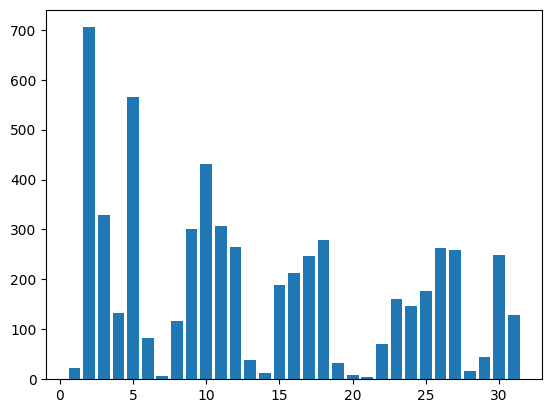

In [66]:

# Let's analize dependence number calls  of day for each month. This data is for january. 
# If you get data for other months, you can see that we have days when number of call is very small.  
# This happens with a frequency of 7 days. Let's consider these days as Sundays. When I analyzed all the months,
# I concluded that June, July, August, September, October, November, December looks like 2020 year. 
# January, February, March, April, March and May looks like 2021 year.

# So I'm going to add feature "day_of_week" and analize dependence number calls  of day of week.

f_group_day = Train[(Train.month=='mar')].groupby(["day"], as_index=False)[["id"]].count()
f_group_day.rename(columns={'id': 'count_calls'}, inplace=True)
plt.bar( f_group_day.day, f_group_day.count_calls)

In [67]:
# If you get data for other months you can see that we have days when number of call is very small.  
# This happens with a frequency of 7 days. Let's consider these days as Sundays. When I analyzed all the months,
# I concluded that June, July, August, September, October, November, December looks like 2020 year. 
# January, February, March, April, March and May looks like 2021 year.

# So I'm going to add feature "day_of_week" and analize dependence number calls  of day of week.

In [68]:
day_month = {"jun" : 0, "jul" : 30, "aug" : 61, "sep": 92, "oct" : 122, "nov":153, "dec":183, "jan":214, "feb":245, "mar": 273, "apr":304, "may": 334 }


Train["number_day"] = Train.apply(lambda x: x.day+day_month[x.month], axis=1) 
    #X["number_day_year"] = X.apply(lambda x: x.day+day_month_year[x.month], axis=1) 

Train["day_of_week"]="unknown"
Train["day_of_week"] = Train.apply(lambda x: "monday" if (x["number_day"] % 7 == 1) else x["day_of_week"], axis=1) 
Train["day_of_week"] = Train.apply(lambda x: "tuesday" if x["number_day"] % 7 == 2 else x["day_of_week"], axis=1) 
Train["day_of_week"] = Train.apply(lambda x: "wednesday" if x["number_day"] % 7 == 3 else x["day_of_week"], axis=1)
Train["day_of_week"] = Train.apply(lambda x: "thursday" if x["number_day"] % 7 == 4 else x["day_of_week"], axis=1)
Train["day_of_week"] = Train.apply(lambda x: "friday" if x["number_day"] % 7 == 5 else x["day_of_week"], axis=1)
Train["day_of_week"] = Train.apply(lambda x: "saterday" if x["number_day"] % 7 == 6 else x["day_of_week"], axis=1)
Train["day_of_week"] = Train.apply(lambda x: "sunday" if x["number_day"] % 7 == 0 else x["day_of_week"], axis=1)
Train["day_of_week"] = Train.apply(lambda x: "unknown" if x["day"] == -1 else x["day_of_week"] , axis=1)

<BarContainer object of 7 artists>

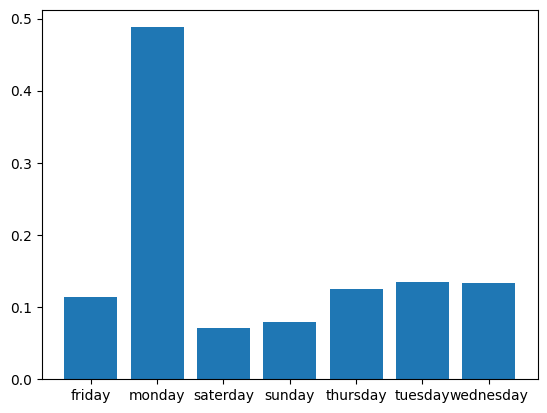

In [69]:

Df_group = Train.groupby("day_of_week")['y'].agg(['count', 'sum'])
Df_group["success"] = Df_group["sum"]/Df_group["count"]

plt.bar( Df_group.index, Df_group.success)

# We can see that successeful rate depends on day of week
# So, I' am going to add feature "day of week"

In [70]:
Train = Train.drop(["day_of_week", "number_day"], axis=1 )

# Feature Engeneering

In [71]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(Train.drop("y", axis=1), Train.y, stratify = Train.y,
                                                    train_size=0.7, 
                                                    random_state=42)

In [72]:
#  prepare data
def prepare_data(X_in):
    X=X_in.copy()
    last_day_month = {"jan" : 31, "feb" : 28, "mar" : 31, "apr": 30, "may" : 31, "jun":30, "jul":31, "aug":31, "sep":30, "oct": 31, "nov":30, "dec": 31 }
    day_month = {"jun" : 0, "jul" : 30, "aug" : 61, "sep": 92, "oct" : 122, "nov":153, "dec":183, "jan":214, "feb":245, "mar": 273, "apr":304, "may": 334 }
    X["last_day"] = X.apply(lambda x: "yes" if x['day'] == last_day_month[x['month']] else "no", axis=1)
    X.day = X.apply(lambda x: -1 if (x['last_day'] == "no") & (x['day'] == 31) else x["day"], axis=1)
    X.day = X.apply(lambda x: -1 if (x['month'] == "feb") & (x['day'] == 31) else x["day"], axis=1)
    X.day = X.apply(lambda x: -1 if (x['month'] == "feb") & (x['day'] == 30) else x["day"], axis=1)
    X.day = X.apply(lambda x: -1 if (x['month'] == "feb") & (x['day'] == 29) else x["day"], axis=1)
    #
    X["number_day"] = X.apply(lambda x: x.day+day_month[x.month], axis=1) 
    #X["number_day_year"] = X.apply(lambda x: x.day+day_month_year[x.month], axis=1) 

    X["day_of_week"]="unknown"
    X["day_of_week"] = X.apply(lambda x: "monday" if (x["number_day"] % 7 == 1) else x["day_of_week"], axis=1) 
    X["day_of_week"] = X.apply(lambda x: "tuesday" if x["number_day"] % 7 == 2 else x["day_of_week"], axis=1) 
    X["day_of_week"] = X.apply(lambda x: "wednesday" if x["number_day"] % 7 == 3 else x["day_of_week"], axis=1)
    X["day_of_week"] = X.apply(lambda x: "thursday" if x["number_day"] % 7 == 4 else x["day_of_week"], axis=1)
    X["day_of_week"] = X.apply(lambda x: "friday" if x["number_day"] % 7 == 5 else x["day_of_week"], axis=1)
    X["day_of_week"] = X.apply(lambda x: "saterday" if x["number_day"] % 7 == 6 else x["day_of_week"], axis=1)
    X["day_of_week"] = X.apply(lambda x: "sunday" if x["number_day"] % 7 == 0 else x["day_of_week"], axis=1)
    X["day_of_week"] = X.apply(lambda x: "unknown" if x["day"] == -1 else x["day_of_week"] , axis=1)
    
    X["weekend"] = X.apply(lambda x: "yes" if (x["day_of_week"] == "monday") | (x["day_of_week"] == "sanday") else "no" , axis=1)
    for column in list(X.select_dtypes(include='int64').columns):
        if column!="id":
            X[column] = X[column].astype("int32")
    X = X.drop("number_day", axis=1)


    return X 

In [73]:
# function for fit OneHotEncoder
def Ohe_fit(X_in, features_to_ohe):
    X=X_in.copy()
    ohe =OneHotEncoder(sparse_output=False, drop = "if_binary", handle_unknown='ignore')
    ohe.fit(X[features_to_ohe])
    return ohe

In [74]:
#function for transform data by OneHotEncoder
def Ohe_transform(ohe, X_in, features_to_ohe):
    X=X_in.copy()

    encoded_data = ohe.transform(X[features_to_ohe])
    encoded_data = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())
    X = pd.concat([X.reset_index(), encoded_data.reset_index()], axis=1)    
    for column in ohe.get_feature_names_out():
        if column!="id":
            X[column] = X[column].astype("int8")
    X = X.drop(features_to_ohe, axis=1)
    return X

# Modelling

In [75]:
#Data Preparation

X_train_tuned = prepare_data(X_train)
X_test_tuned = prepare_data(X_test)


In [76]:
# I am going to label encode all categorical features
features_to_label=['job', 'marital', 'education', 'default','housing','loan','contact','month','poutcome','last_day','day_of_week', 'weekend']
LE = LabelEncoder()
for feature in features_to_label:
    LE.fit(X_train_tuned[feature])
    X_train_tuned[feature+"_label"] = LE.transform(X_train_tuned[feature])
    X_test_tuned[feature+"_label"] = LE.transform(X_test_tuned[feature])

In [77]:
X_train_tuned.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,...,education_label,default_label,housing_label,loan_label,contact_label,month_label,poutcome_label,last_day_label,day_of_week_label,weekend_label
653487,653487,44,blue-collar,married,primary,no,684,yes,no,unknown,...,0,0,1,0,2,6,3,0,4,0
384165,384165,35,management,divorced,tertiary,no,5,yes,no,unknown,...,2,0,1,0,2,6,3,0,7,0
20438,20438,59,technician,married,primary,no,3037,yes,no,unknown,...,0,0,1,0,2,6,3,0,0,0
670047,670047,41,admin.,divorced,secondary,no,-97,yes,no,unknown,...,1,0,1,0,2,8,3,0,3,0
408012,408012,55,housemaid,married,primary,no,0,no,no,unknown,...,0,0,0,0,2,6,3,0,0,0


In [78]:
# convert types to take care computational resources
for column in list(X_train_tuned.select_dtypes(include='int64').columns):
        if column!="id":
            X_train_tuned[column] = X_train_tuned[column].astype("int8")
            X_test_tuned[column] = X_test_tuned[column].astype("int8")

In [79]:
features_to_ohe=  ['job', 'marital', 'education', 'default','housing','loan','contact','month','poutcome','last_day','day_of_week', 'weekend','day']

In [80]:
X_train_tuned

,id,age,job,marital,education,default,balance,housing,loan,contact,...,education_label,default_label,housing_label,loan_label,contact_label,month_label,poutcome_label,last_day_label,day_of_week_label,weekend_label
653487,653487,44,blue-collar,married,primary,no,684,yes,no,unknown,...,0,0,1,0,2,6,3,0,4,0
384165,384165,35,management,divorced,tertiary,no,5,yes,no,unknown,...,2,0,1,0,2,6,3,0,7,0
20438,20438,59,technician,married,primary,no,3037,yes,no,unknown,...,0,0,1,0,2,6,3,0,0,0
670047,670047,41,admin.,divorced,secondary,no,-97,yes,no,unknown,...,1,0,1,0,2,8,3,0,3,0
408012,408012,55,housemaid,married,primary,no,0,no,no,unknown,...,0,0,0,0,2,6,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549877,549877,37,technician,married,secondary,no,4389,yes,no,cellular,...,1,0,1,0,0,1,3,0,2,0
140612,140612,40,management,married,tertiary,no,3158,yes,no,cellular,...,2,0,1,0,0,5,3,1,0,0
318186,318186,34,technician,married,secondary,no,-32,no,no,cellular,...,1,0,0,0,0,1,3,0,5,0
527966,527966,37,management,single,tertiary,no,810,yes,no,unknown,...,2,0,1,0,2,8,3,0,4,0


In [81]:
#I am going to combine featuers pairs and encode pairs by count encoder

all_features=X_train_tuned.columns
features_to_count_encoding = []
for feature in all_features:
    if(feature!="id"):
        for feature1 in all_features:
           if(feature1!="id") and  (feature1!=feature) and ((feature1+"_"+feature) not in X_train_tuned.columns) and (feature not in features_to_label) and (feature1 not in features_to_label): 
               X_train_tuned[feature+"_"+feature1] = X_train_tuned[feature].astype(str)+"+"+X_train_tuned[feature1].astype (str)
               X_test_tuned[feature+"_"+feature1] = X_test_tuned[feature].astype(str)+"+"+X_test_tuned[feature1].astype(str)
               features_to_count_encoding.append(feature+"_"+feature1)

In [82]:
# Count Encoder
CE=CountEncoder(cols=features_to_count_encoding)


In [83]:
CE.fit(X_train_tuned, y_train)

CountEncoder(cols=['age_balance', 'age_day', 'age_duration', 'age_campaign',
                   'age_pdays', 'age_previous', 'age_job_label',
                   'age_marital_label', 'age_education_label',
                   'age_default_label', 'age_housing_label', 'age_loan_label',
                   'age_contact_label', 'age_month_label', 'age_poutcome_label',
                   'age_last_day_label', 'age_day_of_week_label',
                   'age_weekend_label', 'balance_day', 'balance_duration',
                   'balance_campaign', 'balance_pdays', 'balance_previous',
                   'balance_job_label', 'balance_marital_label',
                   'balance_education_label', 'balance_default_label',
                   'balance_housing_label', 'balance_loan_label',
                   'balance_contact_label', ...],
             combine_min_nan_groups=True)

In [84]:
feature_label = []
for feature in features_to_label:
    feature_label.append(feature+"_label")
feature_label
feature_label

['job_label',
 'marital_label',
 'education_label',
 'default_label',
 'housing_label',
 'loan_label',
 'contact_label',
 'month_label',
 'poutcome_label',
 'last_day_label',
 'day_of_week_label',
 'weekend_label']

In [85]:
X_test_tuned.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,...,month_label_poutcome_label,month_label_last_day_label,month_label_day_of_week_label,month_label_weekend_label,poutcome_label_last_day_label,poutcome_label_day_of_week_label,poutcome_label_weekend_label,last_day_label_day_of_week_label,last_day_label_weekend_label,day_of_week_label_weekend_label
84220,84220,45,technician,single,tertiary,no,796,no,no,unknown,...,6+3,6+0,6+2,6+0,3+0,3+2,3+0,0+2,0+0,2+0
337312,337312,40,technician,married,secondary,no,0,yes,no,cellular,...,5+3,5+0,5+4,5+0,3+0,3+4,3+0,0+4,0+0,4+0
351533,351533,47,services,married,secondary,no,512,no,no,cellular,...,1+3,1+0,1+2,1+0,3+0,3+2,3+0,0+2,0+0,2+0
556219,556219,27,housemaid,single,secondary,no,-18,no,yes,unknown,...,5+3,5+0,5+3,5+0,3+0,3+3,3+0,0+3,0+0,3+0
267294,267294,53,blue-collar,married,secondary,no,3696,no,no,cellular,...,0+2,0+0,0+1,0+1,2+0,2+1,2+1,0+1,0+1,1+1


In [86]:
X_train_tuned=CE.transform(X_train_tuned)
X_test_tuned=CE.transform(X_test_tuned)
X_train_tuned=X_train_tuned.drop(feature_label, axis=1)
X_test_tuned=X_test_tuned.drop(feature_label, axis=1)

In [87]:
#fit One Hot Encoder
Ohe_train_my = Ohe_fit(X_train_tuned, features_to_ohe)


In [88]:
#Transform train data by One Hot Encoder
X_train_tuned = Ohe_transform(Ohe_train_my, X_train_tuned, features_to_ohe)
X_train_tuned.head()

,index,id,age,balance,duration,campaign,pdays,previous,age_balance,age_day,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,653487,653487,44,684,643,1,-1,0,10,507,...,0,0,0,0,0,0,0,0,0,0
1,384165,384165,35,5,244,1,-1,0,118,410,...,0,0,0,0,0,0,0,0,0,0
2,20438,20438,59,3037,591,1,-1,0,1,649,...,0,0,0,0,0,0,0,0,0,0
3,670047,670047,41,-97,263,3,-1,0,20,540,...,0,0,0,0,0,0,0,0,0,0
4,408012,408012,55,0,143,1,-1,0,1605,524,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Transform test data by One Hot Encoder
X_test_tuned = Ohe_transform(Ohe_train_my, X_test_tuned, features_to_ohe)
X_test_tuned.head()

,index,id,age,balance,duration,campaign,pdays,previous,age_balance,age_day,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,84220,84220,45,796,623,2,-1,0,9.0,949.0,...,0,0,0,0,0,0,0,0,0,0
1,337312,337312,40,0,129,6,-1,0,1858.0,592.0,...,0,0,0,0,0,0,0,0,0,0
2,351533,351533,47,512,128,11,-1,0,3.0,638.0,...,0,0,0,0,0,0,0,1,0,0
3,556219,556219,27,-18,130,1,-1,0,9.0,185.0,...,0,0,0,0,1,0,0,0,0,0
4,267294,267294,53,3696,855,1,182,2,6.0,286.0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
X_train_tuned=X_train_tuned.drop(["index", "id"], axis=1)
X_test_tuned=X_test_tuned.drop(["index", "id"], axis=1)

## Modelling

In [91]:
# Optuna Hyperparameters tuning LGBMClassifier

def objective(trial):    
    param = {
        'n_jobs':-1, 
        'eval_metric' : "auc",   
        'random_state':42,
        'verbosity':-1,
        'n_estimators':trial.suggest_int('n_estimators',1000,6000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 30),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.04),
        'num_leaves': trial.suggest_int('num_leaves', 30, 200),
        'max_depth':trial.suggest_int('max_depth', 5, 15),
        'max_bin':trial.suggest_int('max_bin', 100, 5000),
        'min_child_samples':  trial.suggest_int('min_child_samples', 3, 30),
    }
    model = LGBMClassifier(**param)  
    model.fit(X_train_tuned, y_train)
    y_LGBM = model.predict_proba(X_test_tuned)
    roc_auc =roc_auc_score(y_test, y_LGBM[:,1])
    return roc_auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [92]:
X_train_tuned.shape

(525000, 260)

## Modelling on all data

In [93]:
#Repeat all steps on full data

In [94]:
Train_tuned = prepare_data(Train.drop("y", axis=1))
X_val_tuned = prepare_data(X_val)

In [95]:
features_to_label=['job', 'marital', 'education', 'default','housing','loan','contact','month','poutcome','last_day','day_of_week', 'weekend']
features_to_ohe=['job', 'marital', 'education', 'default','housing','loan','contact','month','poutcome','last_day','day_of_week', 'weekend', 'day']

In [96]:
Train_tuned.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,last_day,day_of_week,weekend
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,no,tuesday,no
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,no,thursday,no
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,no,friday,no
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,no,friday,no
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,no,wednesday,no


In [97]:
LE = LabelEncoder()
for feature in features_to_label:
    LE.fit(Train_tuned[feature])
    Train_tuned[feature+"_label"] = LE.transform(Train_tuned[feature])
    X_val_tuned[feature+"_label"] = LE.transform(X_val_tuned[feature])



In [98]:
for column in list(Train_tuned.select_dtypes(include='int64').columns):
        if column!="id":
            Train_tuned[column] = Train_tuned[column].astype("int32")
            X_val_tuned[column] = X_val_tuned[column].astype("int32")


In [ ]:
all_features=Train_tuned.columns
features_to_count_encoding = []
for feature in all_features:
    if(feature!="id"):
        for feature1 in all_features:
           if(feature1!="id") and (feature1!=feature) and ((feature1+"_"+feature) not in Train_tuned.columns) and (feature not in features_to_label) and (feature1 not in features_to_label): 
               Train_tuned[feature+"_"+feature1] = Train_tuned[feature].astype(str)+"+"+Train_tuned[feature1].astype(str)
               X_val_tuned[feature+"_"+feature1] = X_val_tuned[feature].astype(str)+"+"+X_val_tuned[feature1].astype(str)
               features_to_count_encoding.append(feature+"_"+feature1)

In [ ]:
# Count Encoder
CE=CountEncoder(cols=features_to_count_encoding)

In [ ]:
CE.fit(Train_tuned, Train.y)

In [ ]:
feature_label = []
for feature in features_to_label:
    feature_label.append(feature+"_label")
feature_label
feature_label

In [ ]:
Train_tuned=CE.transform(Train_tuned)


In [ ]:
X_val_tuned=CE.transform(X_val_tuned)
Train_tuned=Train_tuned.drop(feature_label, axis=1)
X_val_tuned=X_val_tuned.drop(feature_label, axis=1)

In [ ]:
#fit One Hot Encoder
Ohe_train = Ohe_fit(Train_tuned, features_to_ohe)

In [ ]:
Train_tuned = Ohe_transform(Ohe_train, Train_tuned, features_to_ohe)
Train_tuned=Train_tuned.drop(["index", "id"], axis=1)

X_val_tuned = Ohe_transform(Ohe_train, X_val_tuned, features_to_ohe)
X_val_tuned=X_val_tuned.drop(["index", "id"], axis=1)

In [ ]:
#Create LGBM with best parameters

LGBM = LGBMClassifier(
    n_jobs=-1, 
    eval_metric = "auc",   
    random_state=42,
    verbosity=-1,
    n_estimators=4263, 
    learning_rate= 0.036019426144927265,
    min_child_samples=26,
    subsample=0.8251149539458965,
    colsample_bytree= 0.5270990554726177,
    num_leaves=49,
    max_depth= 12,
    max_bin= 2916,
    
    reg_alpha=2.4356357622500435,
    reg_lambda=6.850902607219219,
    )

LGBM.fit(Train_tuned, Train.y)
y_LGBM = LGBM.predict_proba(X_val_tuned)

In [ ]:
df_result = pd.concat([X_val["id"].reset_index(), pd.DataFrame(y_LGBM[:,1], columns=["y"]).reset_index()], axis=1)
df_result=df_result.drop("index", axis=1)
df_result.to_csv("sample_submission.csv", i ndex=False)

In [ ]:
df_result

# My public roc_auc is 0.97501